# Traffic Sign Classification

In [1]:
%matplotlib inline
from IPython.display import display, Markdown

#  # Disable GPU
#  import os
#  os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Traffic sign specific code
import tsdata
import mlutil
import mlvis

print(f"TensorFlow version: {tf.__version__}")
print("GPUs availability: ", tf.config.experimental.list_physical_devices('GPU'))

TensorFlow version: 2.1.0
GPUs availability:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [2]:



task = "part_1b"

if task == "part_1a":
    # High performance model

    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 64,
        target_height = 64,
        is_color_mode = True,
        augmentation  = "fliplr"
    )

    num_classes = 21

    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(dpconfig.target_height, dpconfig.target_width, 3 if dpconfig.is_color_mode else 1)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes)
    ])

    # Larger image classification models - overkill for this problem!

    # base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = dpconfig.get_keras_input_shape()) 
    # x=base_model.output
    # x=tf.keras.layers.GlobalAveragePooling2D()(x)
    # x=tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    # model=tf.keras.Model(base_model.input,x)

    # base_model = tf.keras.applications.NASNetMobile(weights = None, include_top = False, input_shape = dpconfig.get_keras_input_shape()) 
    # x=base_model.output
    # x=tf.keras.layers.GlobalAveragePooling2D()(x)
    # x=tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    # model=tf.keras.Model(base_model.input,x)

    # model = tf.keras.applications.NASNetMobile(weights = None, include_top = True, input_shape = dpconfig.get_keras_input_shape(), classes = num_classes) 

elif task == "part_1b":
    # Smaller model

    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 24,
        target_height = 24,
        is_color_mode = True,
        augmentation  = "fliplr"
    ) 

    num_classes = 21

    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(dpconfig.target_height, dpconfig.target_width, 3 if dpconfig.is_color_mode else 1)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(num_classes)
    ])

elif task == "part_2":
    # Extra emphasis on left and right turn warnings

    dpconfig = tsdata.DataPipelineConfig(
        target_width  = 64,
        target_height = 64,
        is_color_mode = True,
        augmentation  = "fliplr"
    )    

    num_classes = 21

else:
    raise RuntimeError("Invalid task!")

### Calculate computational effort of the model

In [3]:
# flops = keras_flops.get_flops(model, batch_size=1)
# print(f"FLOPS: {flops / 10 ** 9:.03} G")

## Load Data

In [4]:
train_images, train_labels = tsdata.load_data(dpconfig, "train")
test_images,  test_labels  = tsdata.load_data(dpconfig, "test")

class_names = tsdata.get_class_names()

num_classes_actual = len(class_names)

if num_classes_actual != num_classes:
    raise RuntimeError("Unexpected number of classes!")

Loading cached train data...
Loading cached test data...


## Explore the data

In [5]:
print(f"train_images.shape = {train_images.shape}")
print(f"len(train_labels)  = {len(train_labels)}")
print(f"test_images.shape  = {test_images.shape}")
print(f"len(test_labels)   = {len(test_labels)}")

train_images.shape = (31974, 24, 24, 3)
len(train_labels)  = 31974
test_images.shape  = (2156, 24, 24, 3)
len(test_labels)   = 2156


### Visually inspect the data

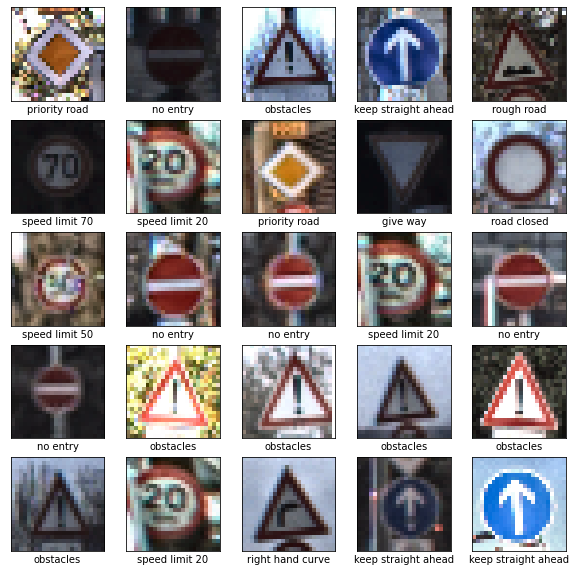

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Train the model

In [7]:
model_family_name = mlutil.generate_model_family_name(dpconfig, friendly_name = task)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback_history     = tf.keras.callbacks.History()
callback_earlystop   = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
callback_checkpoint  = mlutil.get_model_checkpointer(model_family_name)

model.fit(train_images, train_labels, validation_split = 0.2, epochs = 100,
  callbacks = [callback_history, callback_earlystop, callback_checkpoint])

Train on 25579 samples, validate on 6395 samples
Epoch 1/100
25579/25579 [==============================] - 4s 138us/sample - loss: 0.9656 - accuracy: 0.7695 - val_loss: 1.4669 - val_accuracy: 0.6102
Epoch 2/100
25579/25579 [==============================] - 3s 104us/sample - loss: 0.3664 - accuracy: 0.9106 - val_loss: 0.5939 - val_accuracy: 0.8095
Epoch 3/100
25579/25579 [==============================] - 3s 107us/sample - loss: 0.2472 - accuracy: 0.9398 - val_loss: 0.6159 - val_accuracy: 0.8020
Epoch 4/100
25579/25579 [==============================] - 3s 101us/sample - loss: 0.1997 - accuracy: 0.9509 - val_loss: 0.4206 - val_accuracy: 0.8582
Epoch 5/100
25579/25579 [==============================] - 3s 108us/sample - loss: 0.1648 - accuracy: 0.9591 - val_loss: 0.4009 - val_accuracy: 0.8621
Epoch 6/100
25579/25579 [==============================] - 3s 113us/sample - loss: 0.1418 - accuracy: 0.9659 - val_loss: 0.3180 - val_accuracy: 0.8963
Epoch 7/100
25579/25579 [====================

### Determine optimum model

In [8]:
val_losses = np.asarray(callback_history.history["val_loss"])
optimum_epoch_num = np.argmin(val_losses) + 1

print(f"Optimum model: epoch = {optimum_epoch_num}, val_loss = {val_losses[optimum_epoch_num - 1]:.3f}")

print(f"Loading optimum model weights (epoch {optimum_epoch_num})...")
mlutil.load_model_epoch(model, model_family_name, optimum_epoch_num)

Optimum model: epoch = 13, val_loss = 0.207
Loading optimum model weights (epoch 13)...


## Evaluate

In [9]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

2156/2156 - 0s - loss: 0.9756 - accuracy: 0.8989

Test accuracy: 0.8988868


### Make predictions

In [10]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

### Compute confusion matrix

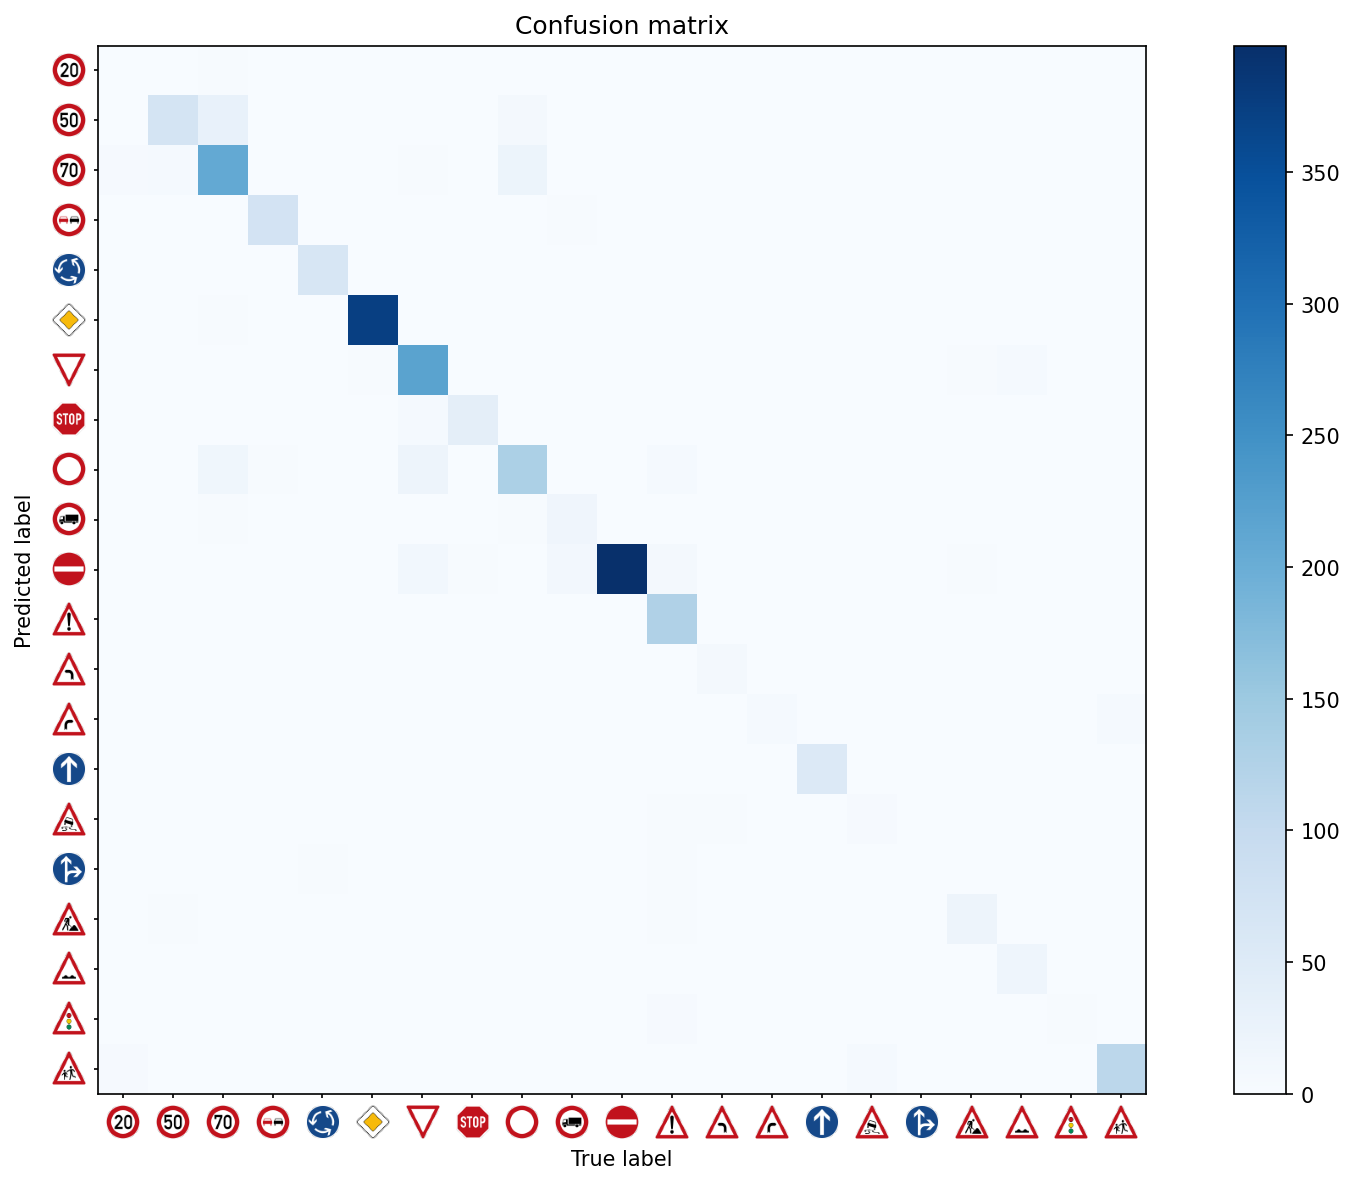

In [19]:
labels_predicted = np.argmax(predictions, axis = 1)

confmat = tf.math.confusion_matrix(test_labels, labels_predicted, num_classes)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150
mlvis.plot_traffic_sign_confmat(confmat, xlabel = 'True label', ylabel = 'Predicted label')

### Verify predictions

Manual inspection of some predictions:

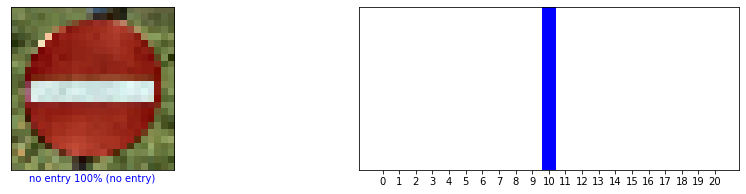

In [12]:
i = 0
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
mlvis.plot_image(i, class_names, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
mlvis.plot_value_array(i, class_names, predictions[i],  test_labels)
plt.show()

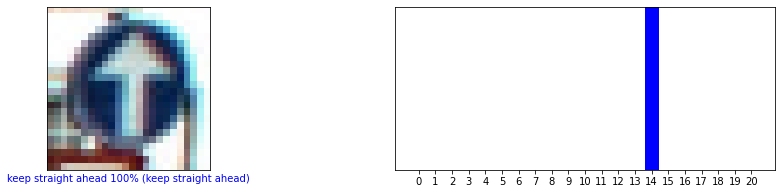

In [13]:
i = 12
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
mlvis.plot_image(i, class_names, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
mlvis.plot_value_array(i, class_names, predictions[i],  test_labels)
plt.show()

Overview of more predictions:

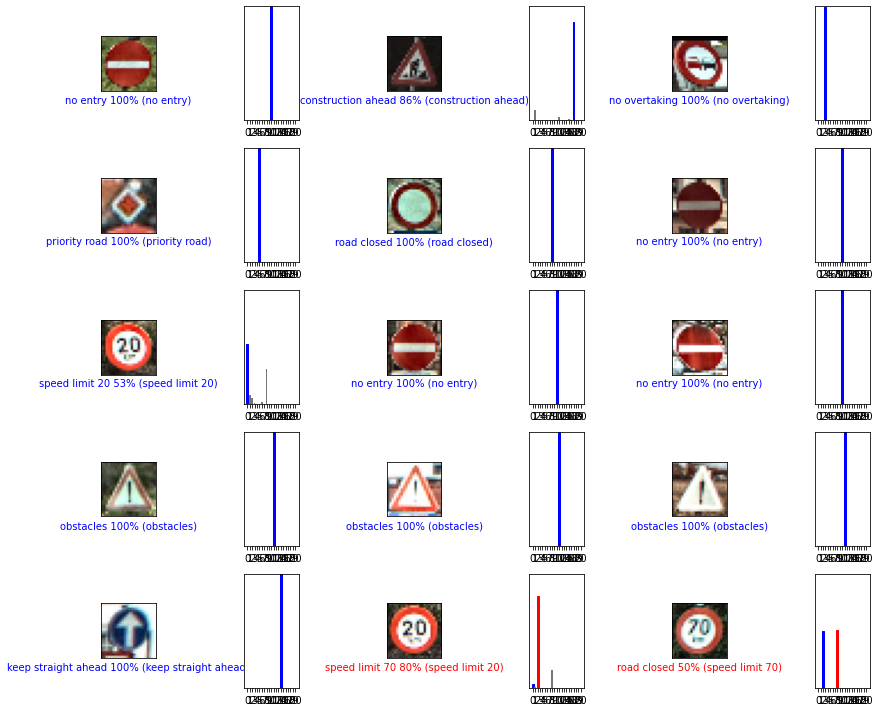

In [14]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mlvis.plot_image(i, class_names, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mlvis.plot_value_array(i, class_names, predictions[i], test_labels)
plt.tight_layout()
plt.show()